# Santander

## Importar librerías

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import math
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [4]:
# 1. leer normal (una sola cabecera)
df = pd.read_csv("../csv/santander_data.csv")

# 2. eliminar las filas “raras” (las 2 primeras)
df = df[~df["Price"].isin(["Ticker", "Date"])].copy()

# 3. renombrar la primera columna porque en realidad es la fecha
df = df.rename(columns={"Price": "Date"})

# 4. convertir la fecha
df["Date"] = pd.to_datetime(df["Date"])

# 5. convertir el resto a numérico
for col in ["Close", "High", "Low", "Open", "Volume"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")


# Para ser coherentes con lo anterior, creamos una columna PRICE fija:
df["Price"] = pd.to_numeric(df["Close"], errors="coerce")

# ordenar por fecha
df = df.sort_values("Date").reset_index(drop=True)

print(df.head())
print(df.dtypes)



        Date     Close      High       Low      Open   Volume     Price
0 2000-01-03  2.625066  2.661974  2.595078  2.652747  8797337  2.625066
1 2000-01-04  2.562785  2.606613  2.539718  2.592773  8811013  2.562785
2 2000-01-05  2.500502  2.546637  2.479741  2.514342  9333517  2.500502
3 2000-01-06  2.500502  2.500502  2.500502  2.500502        0  2.500502
4 2000-01-07  2.611225  2.618145  2.516649  2.518956  9603132  2.611225
Date      datetime64[ns]
Close            float64
High             float64
Low              float64
Open             float64
Volume             int64
Price            float64
dtype: object


## PREPROCESAMIENTO

In [5]:
def preparar_datos_desde_df(df, col_target="Price", window_size=30):
    df = df.sort_values("Date").reset_index(drop=True)

    if col_target not in df.columns:
        raise ValueError(f"No encuentro la columna {col_target}. Tengo: {df.columns.tolist()}")

    valores = df[[col_target]].values.astype(float)

    scaler = MinMaxScaler(feature_range=(0, 1))
    valores_scaled = scaler.fit_transform(valores)

    X, y = [], []
    for i in range(window_size, len(valores_scaled)):
        X.append(valores_scaled[i-window_size:i, 0])
        y.append(valores_scaled[i, 0])

    X = np.array(X)
    y = np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    return X, y, scaler, df

window_size = 30
X_santander, y_santander, scaler_santander, santander_df = preparar_datos_desde_df(df, col_target="Price", window_size=window_size)

print("X_santander:", X_santander.shape)
print("y_santander:", y_santander.shape)



X_santander: (6604, 30, 1)
y_santander: (6604,)


## Train y test temporal

In [6]:
# 80% train, 20% test (temporal, sin shuffle)
train_size = int(len(X_santander) * 0.8)
X_train, X_test = X_santander[:train_size], X_santander[train_size:]
y_train, y_test = y_santander[:train_size], y_santander[train_size:]

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)

Train: (5283, 30, 1) (5283,)
Test : (1321, 30, 1) (1321,)


## Modelos

In [7]:
input_shape = (window_size, 1)

def build_rnn():
    model = Sequential([
        SimpleRNN(64, input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

def build_lstm():
    model = Sequential([
        LSTM(64, input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

def build_gru():
    model = Sequential([
        GRU(64, input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model


## Entrenamiento

In [ ]:
EPOCHS = 1000
BATCH = 32

# Crear carpeta 'modelos' fuera de notebooks si no existe
modelos_dir = os.path.join("..", "modelos")
os.makedirs(modelos_dir, exist_ok=True)

# Callbacks comunes
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=80,             # se detiene si 80 epochs sin mejorar
    restore_best_weights=True
)

def entrenar_modelo(nombre, build_fn, X_train, y_train, X_test, y_test):
    """
    Entrena un modelo (RNN, LSTM o GRU) con EarlyStopping y ModelCheckpoint
    """
    print(f"\nEntrenando modelo {nombre}...\n")
    model = build_fn()

    # Ruta completa donde guardar el modelo
    model_path = os.path.join(modelos_dir, f"mejor_{nombre.lower()}_santander.h5")

    checkpoint = ModelCheckpoint(
        model_path,
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    )
    history = model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH,
        validation_data=(X_test, y_test),
        callbacks=[early_stop, checkpoint],
        verbose=1
    )
    return model, history

# ==============================
# ENTRENAR LOS TRES
# ==============================

rnn_model,  hist_rnn  = entrenar_modelo("RNN",  build_rnn,  X_train, y_train, X_test, y_test)
lstm_model, hist_lstm = entrenar_modelo("LSTM", build_lstm, X_train, y_train, X_test, y_test)
gru_model,  hist_gru  = entrenar_modelo("GRU",  build_gru,  X_train, y_train, X_test, y_test)



Entrenando modelo RNN...

Epoch 1/1000


c:\Users\Usuario\OneDrive\Documentos\GitHub\Aprendizaje_Automatico\env11\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


155/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0130
Epoch 1: val_loss improved from None to 0.00429, saving model to ..\modelos\mejor_rnn_santander.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0047 - val_loss: 0.0043
Epoch 2/1000
158/166 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013
Epoch 2: val_loss improved from 0.00429 to 0.00175, saving model to ..\modelos\mejor_rnn_santander.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 3/1000
157/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.0832e-04
Epoch 3: val_loss improved from 0.00175 to 0.00155, saving model to ..\modelos\mejor_rnn_santander.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.7919e-04 - val_loss: 0.0015
Epoch 4/1000
156/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.1864e-04
Epoch 4: val_loss improved from 0.00155 to 0.00100, saving model to ..\modelos\mejor_rnn_santander.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.9923e-04 - val_loss: 9.9719e-04
Epoch 5/1000
159/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.8650e-04
Epoch 5: val_loss did not improve from 0.00100
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.8626e-04 - val_loss: 0.0013
Epoch 6/1000
159/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.1769e-04
Epoch 6: val_loss improved from 0.00100 to 0.00048, saving model to ..\modelos\mejor_rnn_santander.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.2388e-04 - val_loss: 4.7804e-04
Epoch 7/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7219e-04
Epoch 7: val_loss improved from 0.00048 to 0.00043, saving model to ..\modelos\mejor_rnn_santander.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.7303e-04 - val_loss: 4.2568e-04
Epoch 8/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4654e-04
Epoch 8: val_loss improved from 0.00043 to 0.00040, saving model to ..\modelos\mejor_rnn_santander.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.2012e-04 - val_loss: 3.9628e-04
Epoch 9/1000
161/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0022e-04
Epoch 9: val_loss improved from 0.00040 to 0.00033, saving model to ..\modelos\mejor_rnn_santander.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.7653e-04 - val_loss: 3.2610e-04
Epoch 10/1000
158/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.6265e-04
Epoch 10: val_loss did not improve from 0.00033
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.4880e-04 - val_loss: 4.6576e-04
Epoch 11/1000
159/166 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.3437e-04
Epoch 11: val_loss did not improve from 0.00033
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.2771e-04 - val_loss: 7.0857e-04
Epoch 12/1000
159/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.7299e-04
Epoch 12: val_loss improved from 0.00033 to 0.00025, saving model to ..\modelos\mejor_rnn_santander.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.1643e-04 - val_loss: 2.4653e-04
Epoch 13/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.0574e-04
Epoch 13: val_loss did not improve from 0.00025
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.9385e-04 - val_loss: 4.5982e-04
Epoch 14/1000
158/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.9219e-04
Epoch 14: val_loss improved from 0.00025 to 0.00022, saving model to ..\modelos\mejor_rnn_santander.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.8080e-04 - val_loss: 2.1858e-04
Epoch 15/1000
161/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.7289e-04
Epoch 15: val_loss improved from 0.00022 to 0.00020, saving model to ..\modelos\mejor_rnn_santander.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.6080e-04 - val_loss: 1.9550e-04
Epoch 16/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.6453e-04
Epoch 16: val_loss improved from 0.00020 to 0.00015, saving model to ..\modelos\mejor_rnn_santander.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.5861e-04 - val_loss: 1.5019e-04
Epoch 17/1000
156/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.3188e-04
Epoch 17: val_loss improved from 0.00015 to 0.00014, saving model to ..\modelos\mejor_rnn_santander.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.3588e-04 - val_loss: 1.3825e-04
Epoch 18/1000
161/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1744e-04
Epoch 18: val_loss did not improve from 0.00014
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.2540e-04 - val_loss: 1.9936e-04
Epoch 19/1000
156/166 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2435e-04
Epoch 19: val_loss did not improve from 0.00014
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.1070e-04 - val_loss: 1.5214e-04
Epoch 20/1000
160/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0645e-04
Epoch 20: val_loss improved from 0.00014 to 0.00014, saving model to ..\modelos\mejor_rnn_santander.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.0288e-04 - val_loss: 1.3743e-04
Epoch 21/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9771e-04
Epoch 21: val_loss improved from 0.00014 to 0.00011, saving model to ..\modelos\mejor_rnn_santander.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.9613e-04 - val_loss: 1.1181e-04
Epoch 22/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9406e-04
Epoch 22: val_loss did not improve from 0.00011
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8980e-04 - val_loss: 1.2708e-04
Epoch 23/1000
158/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8194e-04
Epoch 23: val_loss did not improve from 0.00011
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7639e-04 - val_loss: 1.1674e-04
Epoch 24/1000
156/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7571e-04
Epoch 24: val_loss did not improve from 0.00011
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7546e-04 - val_loss: 2.3153e-04
Epoch 25/1000
156/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7579e-04
Epoch 25: val_loss did not improve from 0.00011
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8256e-04 - val_loss: 1.2681e-04
Epoch 26/1000
155/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7099e-04
Epoch 26: val_loss did 

166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.6779e-04 - val_loss: 1.0124e-04
Epoch 28/1000
160/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5772e-04
Epoch 28: val_loss did not improve from 0.00010
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5829e-04 - val_loss: 1.1323e-04
Epoch 29/1000
156/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5235e-04
Epoch 29: val_loss did not improve from 0.00010
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5480e-04 - val_loss: 1.4131e-04
Epoch 30/1000
156/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5633e-04
Epoch 30: val_loss did not improve from 0.00010
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5809e-04 - val_loss: 1.4777e-04
Epoch 31/1000
161/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4511e-04
Epoch 31: val_loss did not improve from 0.00010
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.4880e-04 - val_loss: 1.1053e-04
Epoch 32/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5655e-04
Epoch 32: val_loss did 

166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.3822e-04 - val_loss: 9.7735e-05
Epoch 40/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3666e-04
Epoch 40: val_loss did not improve from 0.00010
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.3878e-04 - val_loss: 1.1308e-04
Epoch 41/1000
158/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3547e-04
Epoch 41: val_loss did not improve from 0.00010
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.3568e-04 - val_loss: 1.2382e-04
Epoch 42/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3641e-04
Epoch 42: val_loss did not improve from 0.00010
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.3247e-04 - val_loss: 1.3745e-04
Epoch 43/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2831e-04
Epoch 43: val_loss did not improve from 0.00010
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.3064e-04 - val_loss: 1.0259e-04
Epoch 44/1000
156/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3619e-04
Epoch 44: val_loss did 

166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.3479e-04 - val_loss: 9.6049e-05
Epoch 46/1000
154/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3022e-04
Epoch 46: val_loss did not improve from 0.00010
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.3455e-04 - val_loss: 1.1241e-04
Epoch 47/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3334e-04
Epoch 47: val_loss did not improve from 0.00010
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.2901e-04 - val_loss: 1.0493e-04
Epoch 48/1000
160/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3540e-04
Epoch 48: val_loss did not improve from 0.00010
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.3289e-04 - val_loss: 1.0366e-04
Epoch 49/1000
160/166 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4308e-04
Epoch 49: val_loss did not improve from 0.00010
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3689e-04 - val_loss: 9.7016e-05
Epoch 50/1000
159/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3523e-04
Epoch 50: val_loss did 

166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.2638e-04 - val_loss: 9.5357e-05
Epoch 65/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3213e-04
Epoch 65: val_loss did not improve from 0.00010
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.2788e-04 - val_loss: 1.4803e-04
Epoch 66/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2805e-04
Epoch 66: val_loss did not improve from 0.00010
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.2444e-04 - val_loss: 1.1484e-04
Epoch 67/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3209e-04
Epoch 67: val_loss did not improve from 0.00010
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.2452e-04 - val_loss: 9.7756e-05
Epoch 68/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2304e-04
Epoch 68: val_loss did not improve from 0.00010
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.2560e-04 - val_loss: 1.3068e-04
Epoch 69/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3456e-04
Epoch 69: val_loss did 

166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0037 - val_loss: 7.1463e-04
Epoch 2/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.6548e-04
Epoch 2: val_loss improved from 0.00071 to 0.00055, saving model to ..\modelos\mejor_lstm_santander.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 7.0336e-04 - val_loss: 5.4872e-04
Epoch 3/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.2121e-04
Epoch 3: val_loss improved from 0.00055 to 0.00038, saving model to ..\modelos\mejor_lstm_santander.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 5.9763e-04 - val_loss: 3.7954e-04
Epoch 4/1000
161/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.5835e-04
Epoch 4: val_loss improved from 0.00038 to 0.00033, saving model to ..\modelos\mejor_lstm_santander.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 5.4660e-04 - val_loss: 3.3440e-04
Epoch 5/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.4554e-04
Epoch 5: val_loss did not improve from 0.00033
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 5.2222e-04 - val_loss: 4.4890e-04
Epoch 6/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.4905e-04
Epoch 6: val_loss did not improve from 0.00033
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 4.6066e-04 - val_loss: 5.7891e-04
Epoch 7/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.9616e-04
Epoch 7: val_loss improved from 0.00033 to 0.00028, saving model to ..\modelos\mejor_lstm_santander.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 4.4024e-04 - val_loss: 2.8269e-04
Epoch 8/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.0358e-04
Epoch 8: val_loss did not improve from 0.00028
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 3.9202e-04 - val_loss: 3.0981e-04
Epoch 9/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.0181e-04
Epoch 9: val_loss improved from 0.00028 to 0.00023, saving model to ..\modelos\mejor_lstm_santander.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.9601e-04 - val_loss: 2.3006e-04
Epoch 10/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.6341e-04
Epoch 10: val_loss did not improve from 0.00023
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.6002e-04 - val_loss: 2.9173e-04
Epoch 11/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.3565e-04
Epoch 11: val_loss improved from 0.00023 to 0.00023, saving model to ..\modelos\mejor_lstm_santander.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.3513e-04 - val_loss: 2.2788e-04
Epoch 12/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.1330e-04
Epoch 12: val_loss improved from 0.00023 to 0.00020, saving model to ..\modelos\mejor_lstm_santander.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.0819e-04 - val_loss: 1.9967e-04
Epoch 13/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.9367e-04
Epoch 13: val_loss did not improve from 0.00020
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.8763e-04 - val_loss: 3.9688e-04
Epoch 14/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.9336e-04
Epoch 14: val_loss did not improve from 0.00020
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.7278e-04 - val_loss: 2.8011e-04
Epoch 15/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.6558e-04
Epoch 15: val_loss improved from 0.00020 to 0.00018, saving model to ..\modelos\mejor_lstm_santander.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.5446e-04 - val_loss: 1.8045e-04
Epoch 16/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.5194e-04
Epoch 16: val_loss did not improve from 0.00018
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.4225e-04 - val_loss: 1.8589e-04
Epoch 17/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.4664e-04
Epoch 17: val_loss did not improve from 0.00018
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.3904e-04 - val_loss: 2.9379e-04
Epoch 18/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.3099e-04
Epoch 18: val_loss improved from 0.00018 to 0.00017, saving model to ..\modelos\mejor_lstm_santander.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 2.1807e-04 - val_loss: 1.6630e-04
Epoch 19/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0488e-04
Epoch 19: val_loss did not improve from 0.00017
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.0720e-04 - val_loss: 2.0659e-04
Epoch 20/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.9615e-04
Epoch 20: val_loss did not improve from 0.00017
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.9816e-04 - val_loss: 1.7099e-04
Epoch 21/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8623e-04
Epoch 21: val_loss improved from 0.00017 to 0.00015, saving model to ..\modelos\mejor_lstm_santander.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.8640e-04 - val_loss: 1.4533e-04
Epoch 22/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9569e-04
Epoch 22: val_loss did not improve from 0.00015
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.8859e-04 - val_loss: 1.4665e-04
Epoch 23/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7800e-04
Epoch 23: val_loss did not improve from 0.00015
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.8048e-04 - val_loss: 2.2058e-04
Epoch 24/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8113e-04
Epoch 24: val_loss did not improve from 0.00015
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.7849e-04 - val_loss: 1.5848e-04
Epoch 25/1000
161/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.6468e-04
Epoch 25: val_loss did not improve from 0.00015
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.6731e-04 - val_loss: 1.6703e-04
Epoch 26/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.5792e-04
Epoch 26: val_

166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.6242e-04 - val_loss: 1.3301e-04
Epoch 27/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.7201e-04
Epoch 27: val_loss improved from 0.00013 to 0.00013, saving model to ..\modelos\mejor_lstm_santander.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.6643e-04 - val_loss: 1.3043e-04
Epoch 28/1000
160/166 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5634e-04
Epoch 28: val_loss did not improve from 0.00013
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.5374e-04 - val_loss: 1.9121e-04
Epoch 29/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5258e-04
Epoch 29: val_loss improved from 0.00013 to 0.00012, saving model to ..\modelos\mejor_lstm_santander.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.4867e-04 - val_loss: 1.1754e-04
Epoch 30/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.4843e-04
Epoch 30: val_loss did not improve from 0.00012
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.5010e-04 - val_loss: 1.3324e-04
Epoch 31/1000
161/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3778e-04
Epoch 31: val_loss did not improve from 0.00012
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.4389e-04 - val_loss: 1.5845e-04
Epoch 32/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.4418e-04
Epoch 32: val_loss did not improve from 0.00012
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.4720e-04 - val_loss: 1.4438e-04
Epoch 33/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3811e-04
Epoch 33: val_loss did not improve from 0.00012
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.3816e-04 - val_loss: 1.6619e-04
Epoch 34/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3534e-04
Epoch 34: val_l

166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.3545e-04 - val_loss: 1.1192e-04
Epoch 35/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4348e-04
Epoch 35: val_loss did not improve from 0.00011
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.4542e-04 - val_loss: 1.8472e-04
Epoch 36/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3017e-04
Epoch 36: val_loss improved from 0.00011 to 0.00011, saving model to ..\modelos\mejor_lstm_santander.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.3368e-04 - val_loss: 1.0810e-04
Epoch 37/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3645e-04
Epoch 37: val_loss did not improve from 0.00011
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.3551e-04 - val_loss: 1.3433e-04
Epoch 38/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3361e-04
Epoch 38: val_loss did not improve from 0.00011
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.3519e-04 - val_loss: 1.1836e-04
Epoch 39/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3963e-04
Epoch 39: val_loss did not improve from 0.00011
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.3338e-04 - val_loss: 1.2215e-04
Epoch 40/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3293e-04
Epoch 40: val_loss did not improve from 0.00011
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.3144e-04 - val_loss: 1.2261e-04
Epoch 41/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3208e-04
Epoch 41: val_

166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.3480e-04 - val_loss: 9.7767e-05
Epoch 44/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3701e-04
Epoch 44: val_loss did not improve from 0.00010
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.3292e-04 - val_loss: 9.9400e-05
Epoch 45/1000
161/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2453e-04
Epoch 45: val_loss did not improve from 0.00010
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.3081e-04 - val_loss: 1.1752e-04
Epoch 46/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3482e-04
Epoch 46: val_loss did not improve from 0.00010
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.3074e-04 - val_loss: 1.2971e-04
Epoch 47/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3090e-04
Epoch 47: val_loss did not improve from 0.00010
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.2949e-04 - val_loss: 9.8091e-05
Epoch 48/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.3860e-04
Epoch 48: val_

166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1.2541e-04 - val_loss: 9.6256e-05
Epoch 66/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.3336e-04
Epoch 66: val_loss did not improve from 0.00010
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.3235e-04 - val_loss: 1.3866e-04
Epoch 67/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.2986e-04
Epoch 67: val_loss did not improve from 0.00010
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.2927e-04 - val_loss: 1.0769e-04
Epoch 68/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.2723e-04
Epoch 68: val_loss did not improve from 0.00010
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.2765e-04 - val_loss: 9.9696e-05
Epoch 69/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2521e-04
Epoch 69: val_loss did not improve from 0.00010
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.2551e-04 - val_loss: 1.1899e-04
Epoch 70/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2486e-04
Epoch 70: val

166/166 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0075 - val_loss: 3.2237e-04
Epoch 2/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.6643e-04
Epoch 2: val_loss improved from 0.00032 to 0.00025, saving model to ..\modelos\mejor_gru_santander.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 6.4221e-04 - val_loss: 2.4744e-04
Epoch 3/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.4324e-04
Epoch 3: val_loss improved from 0.00025 to 0.00020, saving model to ..\modelos\mejor_gru_santander.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 5.2143e-04 - val_loss: 2.0196e-04
Epoch 4/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.6773e-04
Epoch 4: val_loss improved from 0.00020 to 0.00019, saving model to ..\modelos\mejor_gru_santander.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 4.5739e-04 - val_loss: 1.9463e-04
Epoch 5/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.5182e-04
Epoch 5: val_loss did not improve from 0.00019
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 4.5124e-04 - val_loss: 2.1992e-04
Epoch 6/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.1396e-04
Epoch 6: val_loss improved from 0.00019 to 0.00018, saving model to ..\modelos\mejor_gru_santander.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 3.9956e-04 - val_loss: 1.8197e-04
Epoch 7/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.8652e-04
Epoch 7: val_loss did not improve from 0.00018
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3.8391e-04 - val_loss: 1.9252e-04
Epoch 8/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.8389e-04
Epoch 8: val_loss did not improve from 0.00018
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 3.5857e-04 - val_loss: 2.6113e-04
Epoch 9/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.4396e-04
Epoch 9: val_loss improved from 0.00018 to 0.00017, saving model to ..\modelos\mejor_gru_santander.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 3.2635e-04 - val_loss: 1.7220e-04
Epoch 10/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.5120e-04
Epoch 10: val_loss improved from 0.00017 to 0.00017, saving model to ..\modelos\mejor_gru_santander.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3.3914e-04 - val_loss: 1.6850e-04
Epoch 11/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.9903e-04
Epoch 11: val_loss did not improve from 0.00017
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.8481e-04 - val_loss: 1.7847e-04
Epoch 12/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.7130e-04
Epoch 12: val_loss did not improve from 0.00017
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.7372e-04 - val_loss: 2.1286e-04
Epoch 13/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.6904e-04
Epoch 13: val_loss improved from 0.00017 to 0.00016, saving model to ..\modelos\mejor_gru_santander.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.5623e-04 - val_loss: 1.5738e-04
Epoch 14/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.4646e-04
Epoch 14: val_loss did not improve from 0.00016
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 2.4976e-04 - val_loss: 2.0948e-04
Epoch 15/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.5116e-04
Epoch 15: val_loss did not improve from 0.00016
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.4315e-04 - val_loss: 1.6892e-04
Epoch 16/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.1376e-04
Epoch 16: val_loss did not improve from 0.00016
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.1109e-04 - val_loss: 2.0337e-04
Epoch 17/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0958e-04
Epoch 17: val_loss did not improve from 0.00016
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.1640e-04 - val_loss: 2.1004e-04
Epoch 18/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.2867e-04
Epoch 18: val

166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 1.9261e-04 - val_loss: 1.3547e-04
Epoch 20/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.8013e-04
Epoch 20: val_loss improved from 0.00014 to 0.00013, saving model to ..\modelos\mejor_gru_santander.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 1.7890e-04 - val_loss: 1.2536e-04
Epoch 21/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.7504e-04
Epoch 21: val_loss did not improve from 0.00013
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1.7097e-04 - val_loss: 1.2725e-04
Epoch 22/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.7225e-04
Epoch 22: val_loss did not improve from 0.00013
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.6867e-04 - val_loss: 1.8580e-04
Epoch 23/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.7255e-04
Epoch 23: val_loss improved from 0.00013 to 0.00012, saving model to ..\modelos\mejor_gru_santander.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7051e-04 - val_loss: 1.2401e-04
Epoch 24/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.5761e-04
Epoch 24: val_loss did not improve from 0.00012
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.5263e-04 - val_loss: 1.6884e-04
Epoch 25/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.5934e-04
Epoch 25: val_loss improved from 0.00012 to 0.00011, saving model to ..\modelos\mejor_gru_santander.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.5197e-04 - val_loss: 1.0863e-04
Epoch 26/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.5103e-04
Epoch 26: val_loss did not improve from 0.00011
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.5021e-04 - val_loss: 1.4222e-04
Epoch 27/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.3839e-04
Epoch 27: val_loss did not improve from 0.00011
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.4404e-04 - val_loss: 1.6816e-04
Epoch 28/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6043e-04
Epoch 28: val_loss improved from 0.00011 to 0.00010, saving model to ..\modelos\mejor_gru_santander.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.5044e-04 - val_loss: 1.0302e-04
Epoch 29/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.4636e-04
Epoch 29: val_loss did not improve from 0.00010
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1.4264e-04 - val_loss: 1.0445e-04
Epoch 30/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4543e-04
Epoch 30: val_loss improved from 0.00010 to 0.00010, saving model to ..\modelos\mejor_gru_santander.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 1.3707e-04 - val_loss: 1.0205e-04
Epoch 31/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.3852e-04
Epoch 31: val_loss improved from 0.00010 to 0.00010, saving model to ..\modelos\mejor_gru_santander.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.4148e-04 - val_loss: 9.7740e-05
Epoch 32/1000
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.4373e-04
Epoch 32: val_loss did not improve from 0.00010
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 1.3644e-04 - val_loss: 1.1541e-04
Epoch 33/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.3349e-04
Epoch 33: val_loss did not improve from 0.00010
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.3650e-04 - val_loss: 1.0735e-04
Epoch 34/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.4182e-04
Epoch 34: val_loss did not improve from 0.00010
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.3820e-04 - val_loss: 1.2227e-04
Epoch 35/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.2961e-04
Epoch 35: val_loss did not improve from 0.00010
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.3226e-04 - val_loss: 1.1332e-04
Epoch 36/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3815e-04
Epoch 36: val

166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.3860e-04 - val_loss: 9.6414e-05
Epoch 37/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.2370e-04
Epoch 37: val_loss did not improve from 0.00010
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 1.2832e-04 - val_loss: 9.7828e-05
Epoch 38/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.1603e-04
Epoch 38: val_loss did not improve from 0.00010
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.2690e-04 - val_loss: 2.1468e-04
Epoch 39/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.4295e-04
Epoch 39: val_loss did not improve from 0.00010
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.3858e-04 - val_loss: 1.3288e-04
Epoch 40/1000
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.2526e-04
Epoch 40: val_loss did not improve from 0.00010
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.2602e-04 - val_loss: 1.1663e-04
Epoch 41/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.2522e-04
Epoch 41: val

166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.3354e-04 - val_loss: 9.4994e-05
Epoch 55/1000
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.2560e-04
Epoch 55: val_loss did not improve from 0.00009
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1.2991e-04 - val_loss: 1.5395e-04
Epoch 56/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.3335e-04
Epoch 56: val_loss did not improve from 0.00009
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1.3329e-04 - val_loss: 1.1269e-04
Epoch 57/1000
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.2293e-04
Epoch 57: val_loss did not improve from 0.00009
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 1.2846e-04 - val_loss: 1.0063e-04
Epoch 58/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.2610e-04
Epoch 58: val_loss did not improve from 0.00009
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 1.2939e-04 - val_loss: 1.0850e-04
Epoch 59/1000
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.3509e-04
Epoch 59: val

In [9]:
# todas con la misma forma de entrada
input_shape = (window_size, 1)

def build_rnn():
    model = Sequential([
        SimpleRNN(64, input_shape=input_shape),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

def build_lstm():
    model = Sequential([
        LSTM(64, input_shape=input_shape),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

def build_gru():
    model = Sequential([
        GRU(64, input_shape=input_shape),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

## Predicciones

In [10]:
# predicciones (en escala 0-1)
y_pred_rnn  = rnn_model.predict(X_test)
y_pred_lstm = lstm_model.predict(X_test)
y_pred_gru  = gru_model.predict(X_test)

# desescalar
y_test_real = scaler_santander.inverse_transform(y_test.reshape(-1, 1))
pred_rnn_real  = scaler_santander.inverse_transform(y_pred_rnn)
pred_lstm_real = scaler_santander.inverse_transform(y_pred_lstm)
pred_gru_real  = scaler_santander.inverse_transform(y_pred_gru)


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


## Métricas

In [11]:
def evaluar(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse

mae_rnn, rmse_rnn   = evaluar(y_test_real, pred_rnn_real)
mae_lstm, rmse_lstm = evaluar(y_test_real, pred_lstm_real)
mae_gru, rmse_gru   = evaluar(y_test_real, pred_gru_real)

print("RNN  -> MAE:", mae_rnn,  "RMSE:", rmse_rnn)
print("LSTM -> MAE:", mae_lstm, "RMSE:", rmse_lstm)
print("GRU  -> MAE:", mae_gru,  "RMSE:", rmse_gru)


RNN  -> MAE: 0.05274191171630233 RMSE: 0.07596393929378774
LSTM -> MAE: 0.10991360688191486 RMSE: 0.1492297661496703
GRU  -> MAE: 0.05195900926438358 RMSE: 0.07438194593860774


# Graficar

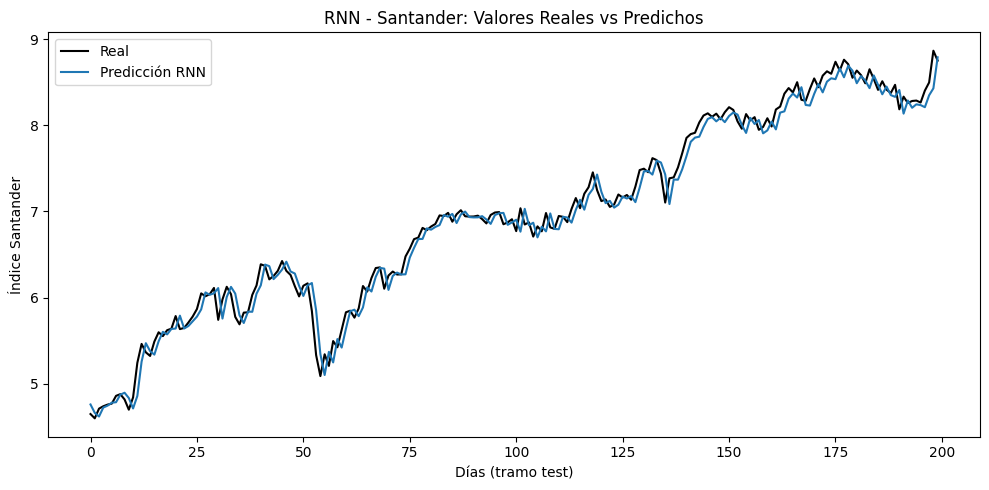

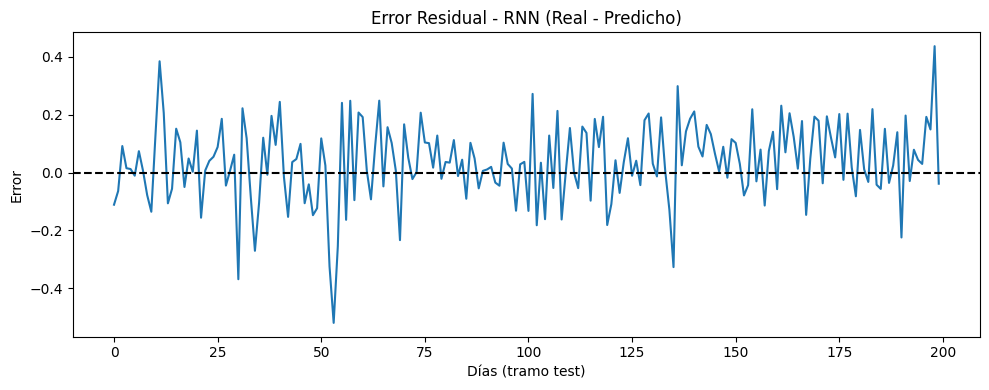

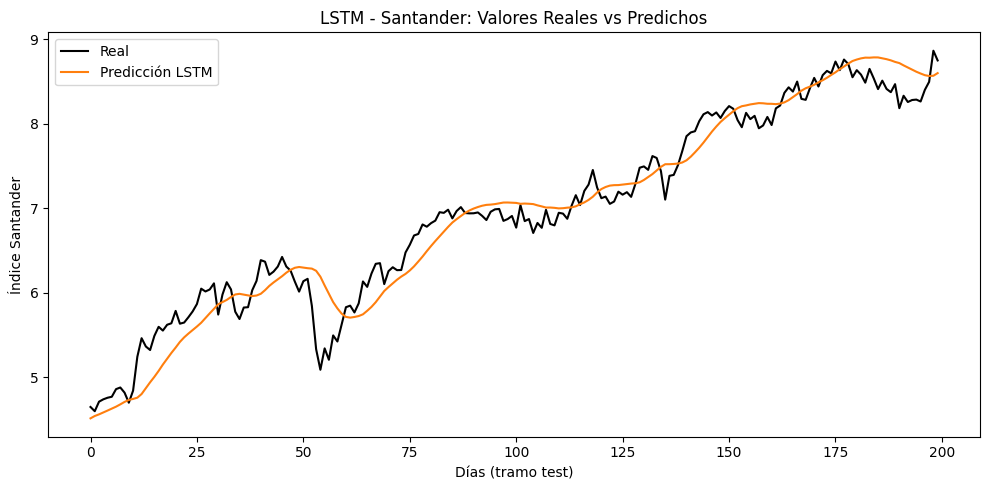

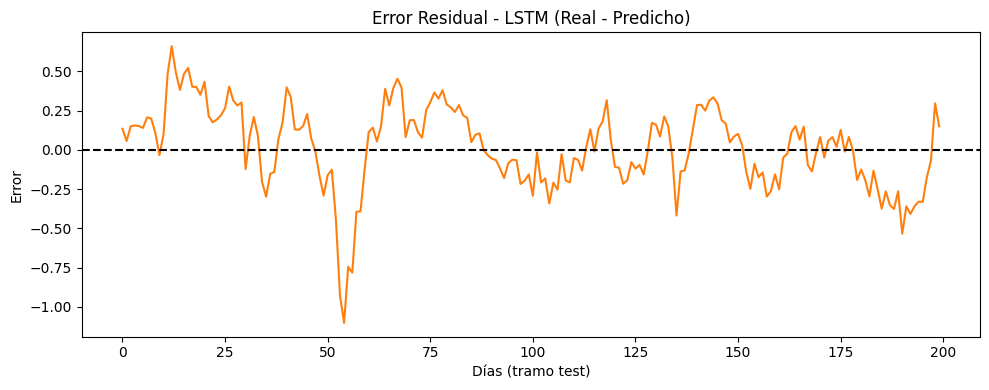

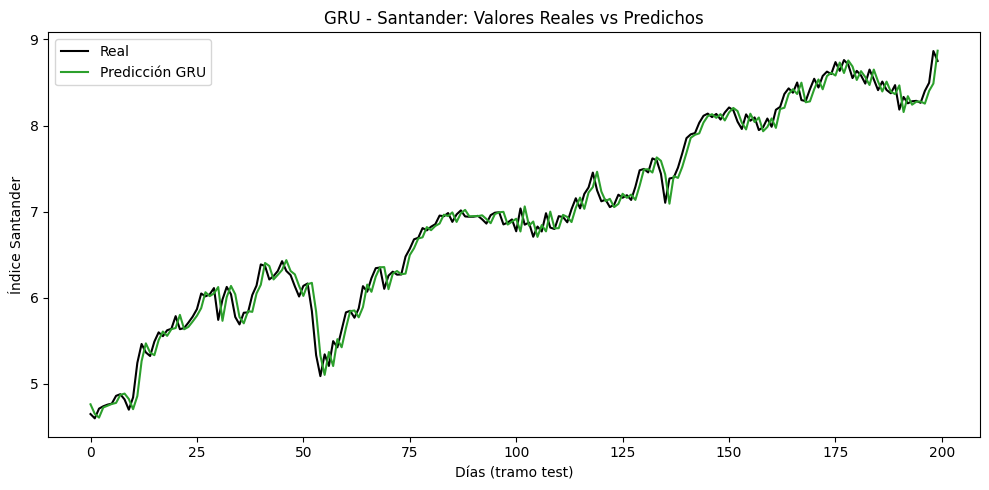

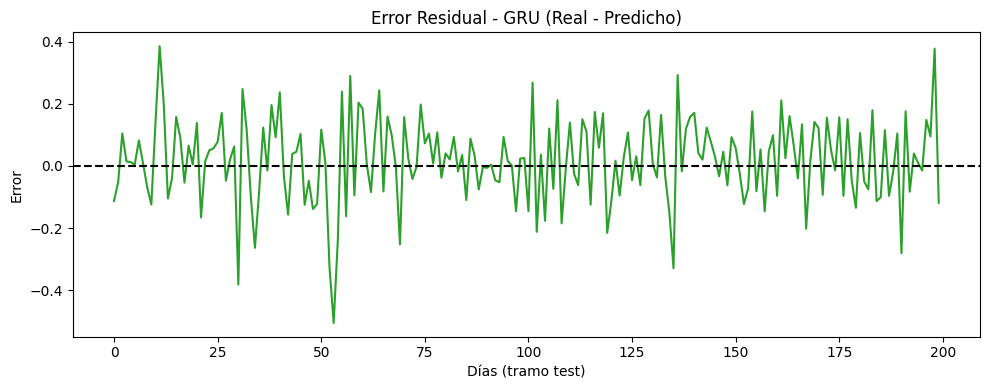

In [12]:
# --- Tramo a mostrar (últimos 200 días del test, por ejemplo) ---
n_mostrar = 200
y_real_plot = y_test_real[-n_mostrar:]
pred_rnn_plot  = pred_rnn_real[-n_mostrar:]
pred_lstm_plot = pred_lstm_real[-n_mostrar:]
pred_gru_plot  = pred_gru_real[-n_mostrar:]

# ===============================
# 1️⃣ RNN
# ===============================
plt.figure(figsize=(10,5))
plt.plot(y_real_plot, label="Real", color="black")
plt.plot(pred_rnn_plot, label="Predicción RNN", color="tab:blue")
plt.title("RNN - Santander: Valores Reales vs Predichos")
plt.xlabel("Días (tramo test)")
plt.ylabel("Índice Santander")
plt.legend()
plt.tight_layout()
plt.show()

# --- Error RNN ---
plt.figure(figsize=(10,4))
plt.plot(y_real_plot - pred_rnn_plot, color="tab:blue")
plt.axhline(0, color="black", linestyle="--")
plt.title("Error Residual - RNN (Real - Predicho)")
plt.xlabel("Días (tramo test)")
plt.ylabel("Error")
plt.tight_layout()
plt.show()

# ===============================
# 2️⃣ LSTM
# ===============================
plt.figure(figsize=(10,5))
plt.plot(y_real_plot, label="Real", color="black")
plt.plot(pred_lstm_plot, label="Predicción LSTM", color="tab:orange")
plt.title("LSTM - Santander: Valores Reales vs Predichos")
plt.xlabel("Días (tramo test)")
plt.ylabel("Índice Santander")
plt.legend()
plt.tight_layout()
plt.show()

# --- Error LSTM ---
plt.figure(figsize=(10,4))
plt.plot(y_real_plot - pred_lstm_plot, color="tab:orange")
plt.axhline(0, color="black", linestyle="--")
plt.title("Error Residual - LSTM (Real - Predicho)")
plt.xlabel("Días (tramo test)")
plt.ylabel("Error")
plt.tight_layout()
plt.show()

# ===============================
# 3️⃣ GRU
# ===============================
plt.figure(figsize=(10,5))
plt.plot(y_real_plot, label="Real", color="black")
plt.plot(pred_gru_plot, label="Predicción GRU", color="tab:green")
plt.title("GRU - Santander: Valores Reales vs Predichos")
plt.xlabel("Días (tramo test)")
plt.ylabel("Índice Santander")
plt.legend()
plt.tight_layout()
plt.show()

# --- Error GRU ---
plt.figure(figsize=(10,4))
plt.plot(y_real_plot - pred_gru_plot, color="tab:green")
plt.axhline(0, color="black", linestyle="--")
plt.title("Error Residual - GRU (Real - Predicho)")
plt.xlabel("Días (tramo test)")
plt.ylabel("Error")
plt.tight_layout()
plt.show()


In [13]:
def predecir_siguiente(model, df_original, scaler, col_target="Price", window_size=30):
    # usamos el df limpio que tenías: santander_df
    ultimos = df_original[[col_target]].values.astype(float)[-window_size:]
    ultimos_scaled = scaler.transform(ultimos)
    X_input = ultimos_scaled.reshape((1, window_size, 1))
    pred_scaled = model.predict(X_input)
    pred = scaler.inverse_transform(pred_scaled)
    return pred[0,0]

pred_manana_lstm = predecir_siguiente(lstm_model, santander_df, scaler_santander, col_target="Price", window_size=window_size)
print("Predicción Santander próximo día (LSTM):", pred_manana_lstm)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicción Santander próximo día (LSTM): 8.638376


## Predecir dias futuros

In [14]:
def predecir_n_dias(model, df_original, scaler, col_target="Price", window_size=30, n_dias=7):
    # 1. cogemos los últimos window_size valores reales
    serie = df_original[[col_target]].values.astype(float)
    ultimos = serie[-window_size:]  # shape (30, 1)

    # los pasamos a escala
    ultimos_scaled = scaler.transform(ultimos)

    preds_desescaladas = []

    # trabajamos en una copia que iremos ampliando
    ventana_actual = ultimos_scaled.copy()  # shape (30,1)

    for _ in range(n_dias):
        # (1, pasos, 1)
        X_input = ventana_actual.reshape((1, window_size, 1))
        pred_scaled = model.predict(X_input, verbose=0)
        # desescalar
        pred_real = scaler.inverse_transform(pred_scaled)[0, 0]
        preds_desescaladas.append(pred_real)

        # ahora actualizamos la ventana: quitamos el 1º y metemos la predicción al final
        nuevo_valor_scaled = pred_scaled  # shape (1,1)
        ventana_actual = np.vstack([ventana_actual[1:], nuevo_valor_scaled])

    return preds_desescaladas

In [15]:
# última fecha real
ultima_fecha = santander_df["Date"].max()

# generamos 7 fechas a partir de la última
fechas_futuras = pd.date_range(start=ultima_fecha + pd.Timedelta(days=1),
                               periods=7, freq="B")  # "B" para días hábiles

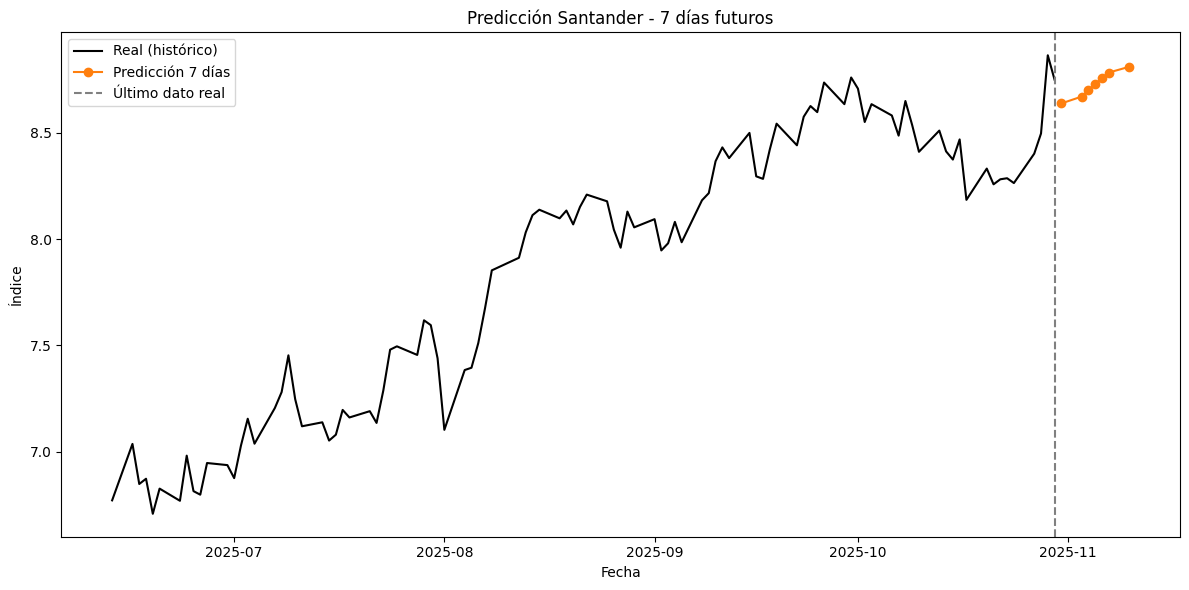

In [16]:
# 1) obtenemos las 7 predicciones
preds_7 = predecir_n_dias(lstm_model, santander_df, scaler_santander,
                          col_target="Price", window_size=window_size, n_dias=7)

# 2) hacemos un DataFrame de futuro
df_futuro = pd.DataFrame({
    "Date": fechas_futuras,
    "Predicted_Price": preds_7
})

# 3) para ver contexto, cogemos los últimos, por ejemplo, 100 días reales
historico_plot = santander_df[["Date", "Price"]].tail(100).copy()

# 4) graficar
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

# parte histórica
plt.plot(historico_plot["Date"], historico_plot["Price"], label="Real (histórico)", color="black")

# parte futura (solo predicción)
plt.plot(df_futuro["Date"], df_futuro["Predicted_Price"],
         label="Predicción 7 días", color="tab:orange", marker="o")

# marcar visualmente el corte
plt.axvline(historico_plot["Date"].max(), color="gray", linestyle="--", label="Último dato real")

plt.title("Predicción Santander - 7 días futuros")
plt.xlabel("Fecha")
plt.ylabel("Índice")
plt.legend()
plt.tight_layout()
plt.show()


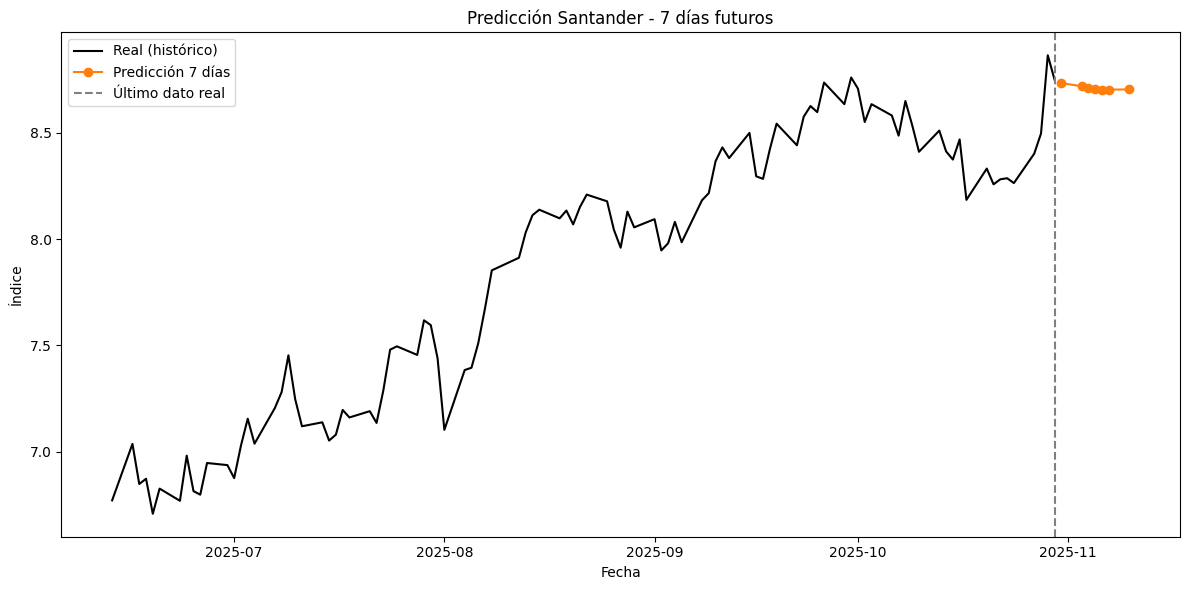

In [18]:
# 1) obtenemos las 7 predicciones
preds_7 = predecir_n_dias(gru_model, santander_df, scaler_santander,
                          col_target="Price", window_size=window_size, n_dias=7)

# 2) hacemos un DataFrame de futuro
df_futuro = pd.DataFrame({
    "Date": fechas_futuras,
    "Predicted_Price": preds_7
})

# 3) para ver contexto, cogemos los últimos, por ejemplo, 100 días reales
historico_plot = santander_df[["Date", "Price"]].tail(100).copy()

# 4) graficar
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

# parte histórica
plt.plot(historico_plot["Date"], historico_plot["Price"], label="Real (histórico)", color="black")

# parte futura (solo predicción)
plt.plot(df_futuro["Date"], df_futuro["Predicted_Price"],
         label="Predicción 7 días", color="tab:orange", marker="o")

# marcar visualmente el corte
plt.axvline(historico_plot["Date"].max(), color="gray", linestyle="--", label="Último dato real")

plt.title("Predicción Santander - 7 días futuros")
plt.xlabel("Fecha")
plt.ylabel("Índice")
plt.legend()
plt.tight_layout()
plt.show()